In [3]:
# -*- coding: utf-8 -*-
"""
    贝叶斯分类器
    ~~~~~~~~~~~~~~~~~~~~~~~~~~
    高斯贝叶斯分类器与强条件独立下的朴素贝叶斯分类器
    :copyright: (c) 2020 by the angusgao.
"""
%matplotlib inline

# 导入所需ListedColormap(从颜色列表生成的Colormap对象。)StratiedShuffleSplit(返回分层的随机褶皱)等库

In [9]:
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import StratifiedShuffleSplit
import  matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import math

In [10]:
# 制作Bayes class [在“各类正态分布”前提下]

In [11]:
class Bayes:
    def __init__(self):
        self.model = None#盛放模型的参数包括协方差矩阵
        self.prior = None#盛放先验概率

    # 数学期望
    @staticmethod
    def mean(X):
        avg = sum(X) / float(len(X))
        return avg
    # covariance matrix
    def cov(self,X,mean):
        dim = len(mean) # 3
        sum = np.zeros((dim,dim))
        for row in X:
            tmp =  np.dot(np.matrix(row-mean).T,np.matrix(row-mean))
            sum += tmp
        return sum * 1/len(X)
    # 标准差（方差）
    def stdev(self,cov):
        res = 0.0
        res = np.linalg.det(cov)
        return res  
    # 处理X_train
    def summarize(self, train_data):
        summaries = [0.0, 0.0]
        summaries = [(i) for i in zip(*train_data)]
        mean = self.mean(train_data)
        cov = self.cov(np.array(train_data),mean)
        summaries = [mean,self.stdev(cov),cov]
        return summaries
     # 类条件概率密度函数
    def gaussian_probability(self, x, mean, stdev,cov):
        res = 0.0
        exponent = math.exp( (-1/2) * np.dot(np.dot((x - mean).T , np.mat(cov).I ),(x-mean)))               
        dim = np.array(x).shape[0]  
        res = (1 / (math.pow(2 * math.pi,dim/2) * stdev)) * exponent     
        return res
    # 分类别求出数学期望和标准差,协方差，先验概率
    def fit(self, X, y):
        labels = list(set(y))
        data = {label: [] for label in labels}
        for f, label in zip(X, y):
            data[label].append(f)
        self.model = {
            label: self.summarize(value) for label, value in data.items()
        }
        self.prior = self.prior_function(y) 
        return 'gaussian_B train done!'
    def prior_function(self,y):
        tmp = Counter(y)
        total = len(y)#总的标签数量 150
        res = {item: value/total for item,value in tmp.items()}   
        return res
    # 计算概率
    def calculate_probabilities(self, input_data):
        probabilities = {}
        for label, value in self.model.items():
            probabilities[label] = self.prior[label]
            mean,stdev,cov = value
            probabilities[label] *= self.gaussian_probability(
                    input_data, mean, stdev,cov)
        return probabilities
    # 类别
    def predict(self, X_test):
        label = sorted(self.calculate_probabilities(X_test).items(), key=lambda x: x[-1])[-1][0]
        return label
    # 计算得分
    def score(self, X_test, y_test):
        right = 0
        for X, y in zip(X_test, y_test):
            label = self.predict(X)
            if label == y:
                right += 1
        return right / float(len(X_test))

# Naive Bayes class

In [12]:
class NaiveBayes:
    def __init__(self):
        self.model = None
        self.prior = None
    # 数学期望
    @staticmethod
    def mean(X):
        avg = 0.0
        avg = sum(X) / float(len(X))
        return avg

    # 标准差（方差）
    def stdev(self, X):
        res = 0.0
        avg = self.mean(X)
        res = math.sqrt(sum([pow(x - avg, 2) for x in X]) / float(len(X)))
        return res
        
    # 类条件概率密度函数
    def gaussian_probability(self, x, mean, stdev):
        res = 0.0
        exponent = math.exp(-(math.pow(x - mean, 2) /
                              (2 * math.pow(stdev, 2))))
        res = (1 / (math.sqrt(2 * math.pi) * stdev)) * exponent       
        return res
        
    # 处理X_train
    def summarize(self, train_data):
        """计算每个类目下对应数据的均值和标准差
        Param: train_data : list
        
        Return : [mean, stdev]
        """
        summaries = [0.0, 0.0]
        summaries = [(self.mean(i), self.stdev(i)) for i in zip(*train_data)]
        return summaries

    # 分类别求出数学期望和标准差
    def fit(self, X, y):
        labels = list(set(y))
        data = {label: [] for label in labels}
        for f, label in zip(X, y):
            data[label].append(f)
        self.model = {
            label: self.summarize(value) for label, value in data.items()
        }
        self.prior = self.prior_function(y) 
        return 'gaussianNB train done!'
    def prior_function(self,y):
        tmp = Counter(y)
        total = len(y)#总的标签数量 150
        res = {item: value/total for item,value in tmp.items()}   
        return res
    # 计算概率
    def calculate_probabilities(self, input_data):
        """计算数据在各个高斯分布下的概率
        Paramter:
        input_data : 输入数据
        
        Return:
        probabilities : {label : p}
        """
        probabilities = {}

        for label, value in self.model.items():
            probabilities[label] = self.prior[label]
            for i in range(len(value)):
                mean, stdev = value[i]
                probabilities[label] *= self.gaussian_probability(
                    input_data[i], mean, stdev)

        return probabilities

    # 类别
    def predict(self, X_test):
        # {0.0: 2.9680340789325763e-27, 1.0: 3.5749783019849535e-26}
        label = sorted(self.calculate_probabilities(X_test).items(), key=lambda x: x[-1])[-1][0]
        return label
    # 计算得分
    def score(self, X_test, y_test):
        right = 0
        for X, y in zip(X_test, y_test):
            label = self.predict(X)
            if label == y:
                right += 1

        return right / float(len(X_test))

# 2d可视化

In [13]:
def show_iris():
    '''
    结合类信息，在二维空间，以不同颜色绘制各样本点，以直观认识不同类别的分布。
    :return: None
    '''
    iris = datasets.load_iris()
    X = iris.data
    y =iris.target
    h = .02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])
    plt.scatter(X[:,0],X[:,1],c=y, cmap=cmap_bold,
           edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class distribution",loc='center')

    plt.show()

In [13]:
def test_GaussianNB(*data):
    '''
    测试 GaussianNB 的用法
    :param data: 可变参数。它是一个元组，这里要求其元素依次为：训练样本集、测试样本集、训练样本的标记、测试样本的标记
    :return: None
    '''
    X_train,X_test,y_train,y_test=data
    #cls=naive_bayes.GaussianNB()
    cls = NaiveBayes()
    cls.fit(X_train,y_train)
    return 1 - cls.score(X_test, y_test)
    
 

In [13]:
   
def test_GaussianB(*data):
    '''
    测试 MultinomialNB 的用法
    :param data: 可变参数。它是一个元组，这里要求其元素依次为：训练样本集、测试样本集、训练样本的标记、测试样本的标记
    :return: None
    '''
    X_train,X_test,y_train,y_test=data
    cls=Bayes()
    cls.fit(X_train,y_train)
    return 1 - cls.score(X_test, y_test)

# 2d可视化

In [13]:
def visiable(clf,X,y):
    h = .02
    
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])
    
    
    #(1) 利用上述所有样本生成最终的决策树模型，完成上述工作。
    clf = clf
    clf.fit(X, y)
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = np.array(X)[:, 0].min() - 1, np.array(X)[:, 0].max() + 1
    y_min, y_max = np.array(X)[:, 1].min() - 1, np.array(X)[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = list()
    for row in np.c_[xx.ravel(), yy.ravel()]:
        Z.append( clf.predict(row) )   
        
    # Put the result into a color plot
    Z = np.array(Z).reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    
    # Plot also the training points
    plt.scatter(np.array(X)[:, 0], np.array(X)[:, 1],cmap=cmap_bold,
                c=np.squeeze(y),edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("%s" % clf)
    
    plt.show() 

In [13]:
if __name__=='__main__':

    show_iris()
    #  加载鸢尾花数据集，保留原始数据集的前2个特征；
    iris = datasets.load_iris()
    X =iris.data[:,0:2]
    y = iris.target[:]
    
    #将其分层随机打乱，均分成m=5等份。拿出任意1份作为测试集、剩余4份作为训练集，得到5个版本的训练集、测试集组合进行学习
    sss = StratifiedShuffleSplit(n_splits=5, test_size=.25, random_state=0) 
  

In [13]:
  
    print("\n+++++贝叶斯分类模型+++++\n")
    i = 1
    score = []
    for train_index, test_index in sss.split(X,y):
        print("############第%d折#############" % i)
        i += 1
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        error = test_GaussianB(X_train,X_test,y_train,y_test)
        print('Testing Error: %.2f' % error)
        score.append(error)
    print('\nAverage Testing Error: %.2f' % np.array(score).mean())
    visiable(Bayes(),X,y)

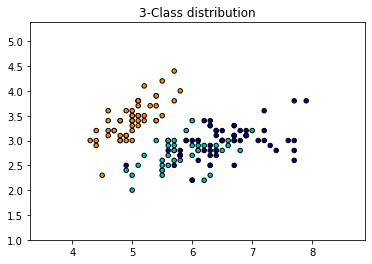


+++++贝叶斯分类模型+++++

############第1折#############
Testing Error: 0.32
############第2折#############
Testing Error: 0.24
############第3折#############
Testing Error: 0.18
############第4折#############
Testing Error: 0.21
############第5折#############
Testing Error: 0.24

Average Testing Error: 0.24


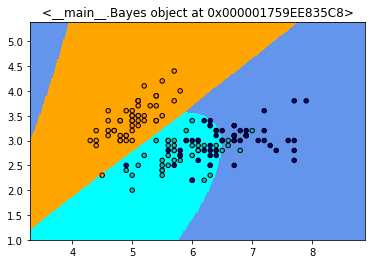


++++高斯朴素贝叶斯分类模型的学习、评价与使用++++++

############第1折#############
Testing Error: 0.29
############第2折#############
Testing Error: 0.24
############第3折#############
Testing Error: 0.11
############第4折#############
Testing Error: 0.21
############第5折#############
Testing Error: 0.18

Average Testing Error: 0.21


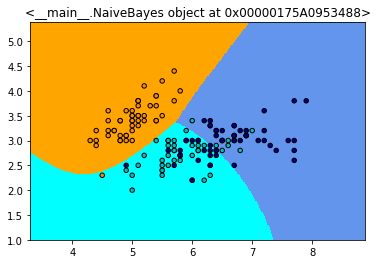

In [13]:
    print("\n++++高斯朴素贝叶斯分类模型的学习、评价与使用++++++\n")
    i = 1
    score = []
    for train_index, test_index in sss.split(X,y):
        print("############第%d折#############" % i)
        i += 1
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        error = test_GaussianNB(X_train,X_test,y_train,y_test)
        print('Testing Error: %.2f' % error)
        score.append(error)
    print('\nAverage Testing Error: %.2f' % np.array(score).mean())
    visiable(NaiveBayes(),X,y)

In [3]:
# data
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:150, :])
    # print(data)
    return data[:,:-1], data[:,-1]